# **Sentiment analysis for market trend prediction**

# **Step 1: Data Loading and Exploration**

**Dataset Description**

**Description:**

There are two channels of data provided in this dataset:

**News data:** The news headlines are from Reddit. They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date.
(Range: 2008-06-08 to 2015-07-01)

**Stock data:** Dow Jones Industrial Average (DJIA) is used to "prove the concept".
(Range: 2008-08-08 to 2015-07-01)

**Files**

**Combined_News_DJIA.csv**- Contain news ranked from top to bottom based on their relevance (25 lines for each date)
**RedditNews.csv**- Contain top 25 news headlines for each date                                                 
**DJIA_table.csv** - stock price data                          
**Test_dates.csv**- dates for prediction

**Columns**                                             
**Combined_News_DJIA.csv(train)**

Date - date on which the news is published

Label - "1" when DJIA Adj Close value rose or stayed as the same, "0" when DJIA Adj Close value decreased.

Top1 - Top25 - Top25 news headlines on that particular date

**RedditNews.csv(train)**

Date - date on which the news is published

News - news headlines on that particular date

**DJIA_table.csv(train)**

Date - date

Open - Opening price of stock

High - Highest price of stock on that particular date

Low - Lowest price of stock on that particular date

Close - Closing price of stock

Volume - The number of trades registered

Adj Close - Adjusted Closing price

**Test_DJIA_dates.csv**

Date - dates for prediction

Open - Opening price of stock

High - Highest price of stock on that particular date

Low - Lowest price of stock on that particular date

Volume - The number of trades registered

**Test_Combined_news.csv**

Date - date on which the news is published

Label - "1" when DJIA Adj Close value rose or stayed as the same, "0" when DJIA Adj Close value decreased.

Top1 - Top25 - Top25 news headlines on that particular date

**Test_Redit_news.csv**

Date - dates for prediction

News -- news headlines on that particular date



**What is DJIA ?**

The **Dow Jones Industrial Average (DJIA)** is a stock market index that measures the performance of 30 large, well-known U.S. companies. It is one of the oldest and most widely followed stock market indices in the world.

The DJIA is calculated as the sum of the closing prices of the 30 component stocks, divided by the divisor. The divisor is adjusted periodically to account for stock splits, dividends, and other corporate actions.

The DJIA is often used as a benchmark for the overall health of the U.S. economy. It is also used by investors to track the performance of their portfolios and to make investment decisions.

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import pipeline  # For sentiment analysis with Transformers


# Load the datasets

In [ ]:
train_news = pd.read_csv('Combined_News_DJIA(train).csv')
train_djia = pd.read_csv('DJIA_table(train).csv')
test_news = pd.read_csv('Test_Combined_News.csv')
test_djia = pd.read_csv('Test_DJIA_Table.csv')


# Date Conversion and Error Handling

In [ ]:
# Use 'mixed' format and errors='coerce' to handle inconsistencies
train_news['Date'] = pd.to_datetime(train_news['Date'], dayfirst=True, errors='coerce')
train_djia['Date'] = pd.to_datetime(train_djia['Date'], dayfirst=True, errors='coerce')
test_news['Date'] = pd.to_datetime(test_news['Date'], dayfirst=True, errors='coerce')
test_djia['Date'] = pd.to_datetime(test_djia['Date'], dayfirst=True, errors='coerce')




# Converting Date Columns to Datetime Format

In [ ]:
train_news['Date'] = pd.to_datetime(train_news['Date'])
train_djia['Date'] = pd.to_datetime(train_djia['Date'])
test_news['Date'] = pd.to_datetime(test_news['Date'])
test_djia['Date'] = pd.to_datetime(test_djia['Date'])


# Sentiment Analysis and Summarization of News Headlines Using BART and FinBERT

In [ ]:
pip install nltk


In [ ]:
pip install transformers torch sentencepiece


In [ ]:
pip install tqdm


In [ ]:
# Import necessary libraries
import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizer, BertForSequenceClassification, BertTokenizer
from tqdm import tqdm  # Import tqdm for progress bar

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load the BART model and tokenizer for summarization
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Load the FinBERT model and tokenizer for sentiment analysis
finbert_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone').to(device)
finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Step 1: Combine the top 25 headlines into a single column
headline_columns = ['Top' + str(i) for i in range(1, 26)]
train_news['Combined_Headlines'] = train_news[headline_columns].apply(lambda row: ' '.join(str(val) for val in row if val), axis=1)

# Function to summarize text using BART
def summarize_text_bart(text, max_length=512, min_length=50):
    inputs = bart_tokenizer([text], max_length=1024, return_tensors='pt', truncation=True).to(device)
    summary_ids = bart_model.generate(inputs['input_ids'], max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to get sentiment score using FinBERT
def get_finbert_sentiment(text):
    inputs = finbert_tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = finbert_model(**inputs)
    sentiment_scores = outputs.logits.softmax(dim=-1).cpu().numpy()
    return sentiment_scores  # Returns probabilities for positive, neutral, negative

# Step 2: Apply summarization and sentiment analysis to the combined headlines with progress bar
tqdm.pandas(desc="Processing News Headlines")  # Set up progress bar description

# Summarize the headlines
train_news['Summary'] = train_news['Combined_Headlines'].progress_apply(summarize_text_bart)

# Get sentiment scores for the summary
train_news['Sentiment_Scores'] = train_news['Summary'].progress_apply(get_finbert_sentiment)

# Extract sentiment labels based on highest score
def extract_sentiment_label(scores):
    labels = ['negative', 'neutral', 'positive']
    return labels[scores.argmax()]

# Apply the function to get sentiment labels
train_news['Sentiment_Label'] = train_news['Sentiment_Scores'].apply(lambda x: extract_sentiment_label(x))

# Print the first few rows of the updated DataFrame
print(train_news[['Date', 'Combined_Headlines', 'Summary', 'Sentiment_Scores', 'Sentiment_Label']].head())

# Count the occurrences of each sentiment label
sentiment_counts = train_news['Sentiment_Label'].value_counts()
print("\nSentiment Counts:")
print(sentiment_counts)

# Optionally, save the results to a new CSV file
train_news.to_csv('train_news_with_sentiment.csv', index=False)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Processing News Headlines: 100%|██████████| 1989/1989 [00:21<00:00, 94.53it/s]


        Date                                 Combined_Headlines  \
0 2008-08-08  b"Georgia 'downs two Russian warplanes' as cou...   
1 2008-11-08  b'Why wont America and Nato help us? If they w...   
2 2008-12-08  b'Remember that adorable 9-year-old who sang a...   
3        NaT  b' U.S. refuses Israel weapons to attack Iran:...   
4        NaT  b'All the experts admit that we should legalis...   

                                             Summary  \
0  b'Georgia 'downs two Russian warplanes' as cou...   
1  b'Why wont America and Nato help us? If they w...   
2  b'Remember that adorable 9-year-old who sang a...   
3  b' U.S. refuses Israel weapons to attack Iran:...   
4  b'Russia exaggerated the death toll in South O...   

                              Sentiment_Scores Sentiment_Label  
0  [[0.9994881, 5.9377857e-05, 0.00045247356]]        negative  
1      [[0.9542639, 0.0051106424, 0.04062541]]        negative  
2  [[4.0641502e-05, 1.5689764e-05, 0.9999436]]        positive  


# Encoding Sentiment Labels into Numerical Values

In [ ]:
# Encode sentiment labels into numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
train_news['Sentiment_Encoded'] = train_news['Sentiment_Label'].replace(sentiment_mapping)

# Check the first few rows of the updated DataFrame
print(train_news[['Date', 'Combined_Headlines', 'Sentiment_Label', 'Sentiment_Encoded']].head())


        Date                                 Combined_Headlines  \
0 2008-08-08  b"Georgia 'downs two Russian warplanes' as cou...   
1 2008-11-08  b'Why wont America and Nato help us? If they w...   
2 2008-12-08  b'Remember that adorable 9-year-old who sang a...   
3        NaT  b' U.S. refuses Israel weapons to attack Iran:...   
4        NaT  b'All the experts admit that we should legalis...   

  Sentiment_Label  Sentiment_Encoded  
0        negative                 -1  
1        negative                 -1  
2        positive                  1  
3        positive                  1  
4        negative                 -1  


# Merging News and Stock Data by Date

In [ ]:
# Load the stock data (assuming it's already loaded in 'train_djia')
# train_djia = pd.read_csv('DJIA_table.csv')  # If not loaded yet

# Ensure the Date columns are in datetime format for both datasets
train_djia['Date'] = pd.to_datetime(train_djia['Date'])

# Merge the datasets on the 'Date' column
merged_data = pd.merge(train_news, train_djia, on='Date', how='inner')

# Check the first few rows of the merged DataFrame
print(merged_data.head())


        Date  Label                                               Top1  \
0 2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1 2008-12-08      0  b'Remember that adorable 9-year-old who sang a...   
2 2008-09-09      0  b'I love the world: Thai Prime Minister Samak ...   
3 2008-10-09      1  b'Dutch to ban burkas when picking children up...   
4 2008-12-09      0     b"OPEC finished??  Saudi Arabia says 'LATER!'"   

                                                Top2  \
0            b'BREAKING: Musharraf to be impeached.'   
1                 b"Russia 'ends Georgia operation'"   
2  b"French revolt over Edvige: Nicolas Sarkozy's...   
3  b"For 21 years a British man has refused to bu...   
4  b'Putin may strip CNN of its Russian broadcast...   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b'"If we had no sexual harassment we would hav...   
2  b'Terrorists Fail! "Time to Carry Liquids on P.

# Preparing Final Dataset for Model Training

In [ ]:
# Selecting relevant features for modeling
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment_Scores']
target = 'Adj Close'  # Target variable to predict

# Create the final dataset with selected features and target
final_data = merged_data[features + [target]]

# Check the first few rows of the final dataset
print(final_data.head())


           Open          High           Low     Volume  \
0  11432.089840  11759.959960  11388.040040  212830000   
1   8637.650391   9026.410156   8637.490234  358970000   
2  11514.730470  11577.500000  11230.730470  257300000   
3   9261.690430   9448.139648   8579.190430  436740000   
4   8934.099609   8934.099609   8651.740234  284950000   

                               Sentiment_Scores     Adj Close  
0   [[0.9994881, 5.9377857e-05, 0.00045247356]]  11734.320310  
1   [[4.0641502e-05, 1.5689764e-05, 0.9999436]]   8934.179688  
2        [[0.5583709, 0.006167466, 0.43546164]]  11230.730470  
3      [[0.54642826, 0.0001102843, 0.45346147]]   8579.190430  
4  [[0.99963224, 2.3972738e-05, 0.00034381435]]   8691.330078  


# **Random Forest**

# Training and Evaluating a Random Forest Regression Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load your merged dataset (assuming it's already done)
# merged_data = pd.read_csv('your_merged_data.csv')  # Uncomment if loading from CSV

# Select features and target
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']  # Adjust as needed
target = 'Adj Close'

X = merged_data[features]
y = merged_data[target]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

# Train the regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Change model as needed
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')


Training set size: (408, 5)
Validation set size: (103, 5)
Mean Squared Error (MSE): 7589.65


# Evaluating Model Performance: MSE and Adj Close Value Range Analysis

In [ ]:
# Find the minimum and maximum of the Adj Close column
min_adj_close = merged_data[target].min()
max_adj_close = merged_data[target].max()

# Calculate the range of Adj Close values
range_adj_close = max_adj_close - min_adj_close

# Compare the MSE to the range
mse_fraction_of_range = mse / range_adj_close

print(f'Minimum Adj Close Value: {min_adj_close}')
print(f'Maximum Adj Close Value: {max_adj_close}')
print(f'Range of Adj Close Values: {range_adj_close:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'MSE as a Fraction of Adj Close Range: {mse_fraction_of_range:.6f}')


Minimum Adj Close Value: 6547.049805
Maximum Adj Close Value: 18288.63086
Range of Adj Close Values: 11741.58
Mean Squared Error (MSE): 7589.65
MSE as a Fraction of Adj Close Range: 0.646391


# Visualization of Predicted vs Actual Adjusted Close Prices

Analyzing the scatter plot of predicted versus actual adjusted close prices can provide valuable insights into the performance of your regression model. Here’s how to interpret the visualization:

1. Diagonal Line
The red dashed line represents the ideal scenario where predicted values perfectly match the actual values. If the points closely follow this line, it indicates good model performance.
2. Point Distribution
Clustered Points: If points cluster around the diagonal line, it suggests that the model is accurately predicting adjusted close prices.
Wide Spread: A wide spread of points away from the diagonal indicates discrepancies between predicted and actual values, suggesting that the model may not be capturing certain trends or patterns effectively.

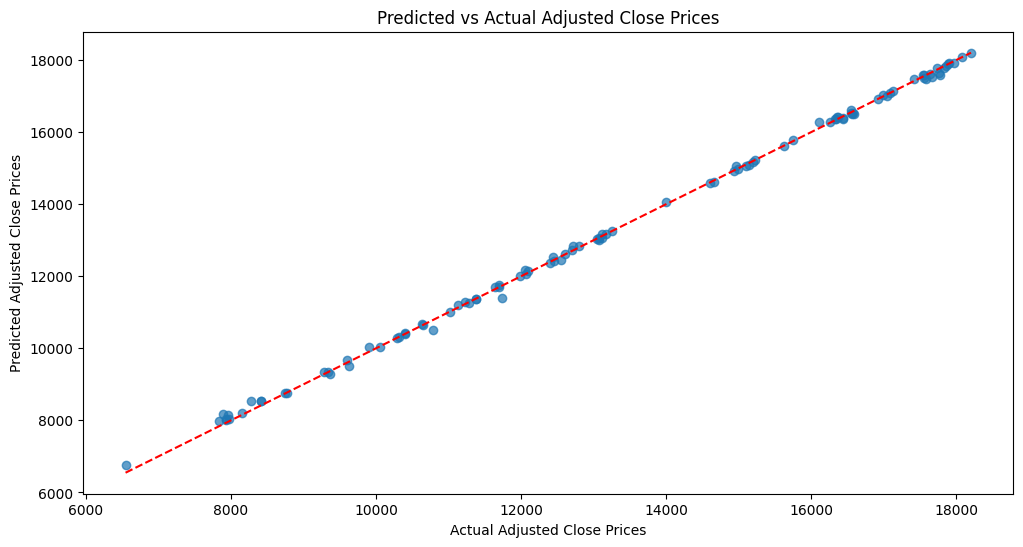

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line
plt.title('Predicted vs Actual Adjusted Close Prices')
plt.xlabel('Actual Adjusted Close Prices')
plt.ylabel('Predicted Adjusted Close Prices')
plt.show()


# **Linear Regression**

# Linear Regression Model: Training, Evaluation, and Performance Visualization

Training set size: (408, 5)
Validation set size: (103, 5)
Mean Squared Error (Linear Regression): 2372.34


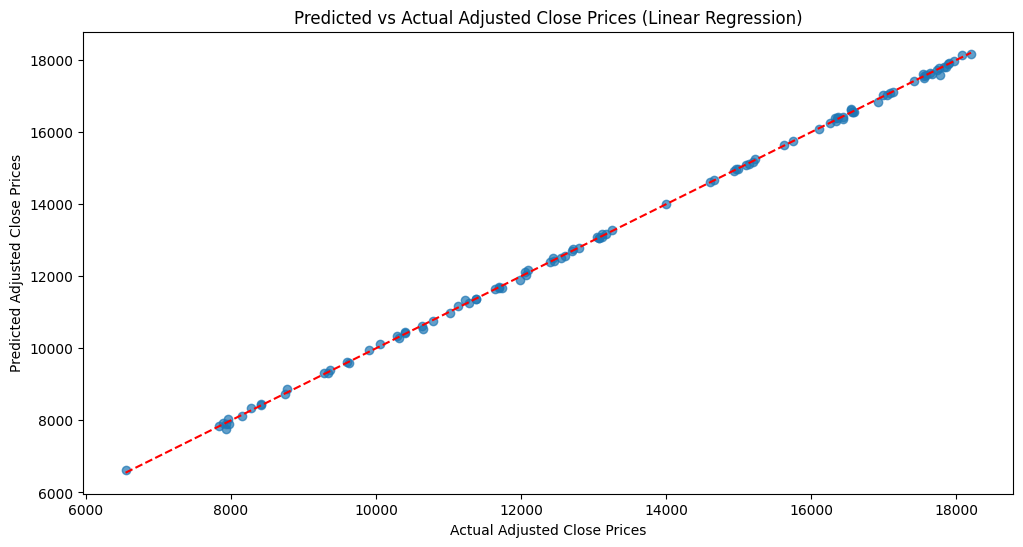

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your merged dataset (assuming it's already done)
# merged_data = pd.read_csv('your_merged_data.csv')  # Uncomment if loading from CSV

# Select features and target
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']  # Adjust as needed
target = 'Adj Close'

X = merged_data[features]
y = merged_data[target]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluate the model
y_pred_linear = linear_model.predict(X_val)
mse_linear = mean_squared_error(y_val, y_pred_linear)
print(f'Mean Squared Error (Linear Regression): {mse_linear:.2f}')

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_linear, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line
plt.title('Predicted vs Actual Adjusted Close Prices (Linear Regression)')
plt.xlabel('Actual Adjusted Close Prices')
plt.ylabel('Predicted Adjusted Close Prices')
plt.show()


# Range Comparison and MSE Fraction Calculation for Linear Regression

In [ ]:
# Calculate the range of actual 'Adj Close' values in the validation set
adj_close_min = y_val.min()
adj_close_max = y_val.max()
adj_close_range = adj_close_max - adj_close_min

# Compare MSE to the range (using the original MSE value)
mse_fraction = mse_linear / adj_close_range  # Use mse_linear for comparison

print(f'Minimum Adj Close Value: {adj_close_min:.2f}')
print(f'Maximum Adj Close Value: {adj_close_max:.2f}')
print(f'Range of Adj Close Values: {adj_close_range:.2f}')
print(f'Mean Squared Error (MSE): {mse_linear:.2f}')
print(f'MSE as a Fraction of Adj Close Range: {mse_fraction:.9f}')


Minimum Adj Close Value: 6547.05
Maximum Adj Close Value: 18203.37
Range of Adj Close Values: 11656.32
Mean Squared Error (MSE): 2372.34
MSE as a Fraction of Adj Close Range: 0.203523970


# **Lasso Regression**

# Training and Evaluation of Lasso Regression Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your merged dataset (assuming it's already done)
# merged_data = pd.read_csv('train_news_with_sentiment.csv')  # Uncomment if loading from CSV

# Select features and target
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']  # Adjust as needed
target = 'Adj Close'

X = merged_data[features]
y = merged_data[target]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

# Train the Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha for regularization strength
lasso_model.fit(X_train, y_train)

# Evaluate the model
y_pred_lasso = lasso_model.predict(X_val)
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
print(f'Mean Squared Error (Lasso Regression): {mse_lasso:.2f}')


Training set size: (408, 5)
Validation set size: (103, 5)
Mean Squared Error (Lasso Regression): 4950.56


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+06, tolerance: 3.689e+05
  model = cd_fast.enet_coordinate_descent(


# Analyzing MSE as a Fraction of 'Adj Close' Value Range for Lasso Regression

In [ ]:
# Calculate the range of actual 'Adj Close' values in the validation set
adj_close_min = y_val.min()
adj_close_max = y_val.max()
adj_close_range = adj_close_max - adj_close_min

# Compare MSE to the range
mse_fraction = mse_lasso / adj_close_range

print(f'Minimum Adj Close Value: {adj_close_min:.2f}')
print(f'Maximum Adj Close Value: {adj_close_max:.2f}')
print(f'Range of Adj Close Values: {adj_close_range:.2f}')
print(f'Mean Squared Error (MSE): {mse_lasso:.2f}')
print(f'MSE as a Fraction of Adj Close Range: {mse_fraction:.9f}')

Minimum Adj Close Value: 6547.05
Maximum Adj Close Value: 18203.37
Range of Adj Close Values: 11656.32
Mean Squared Error (MSE): 4950.56
MSE as a Fraction of Adj Close Range: 0.424710177


# **Ridge Regression**

# Ridge Regression: Predicted vs Actual Adjusted Close Prices and Model Evaluation


Training set size: (408, 5)
Validation set size: (103, 5)
Mean Squared Error (Ridge Regression): 2372.32


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03668e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


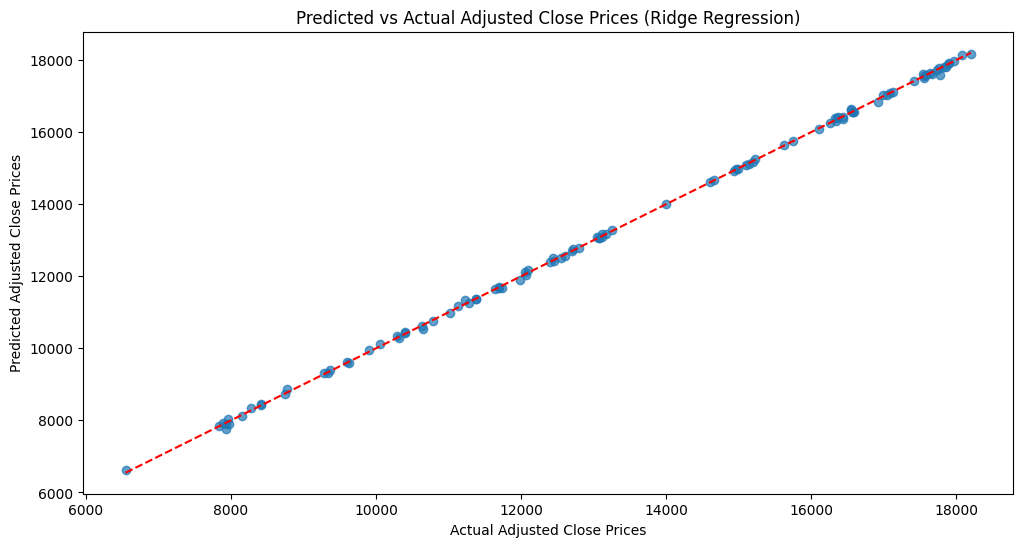

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your merged dataset (assuming it's already done)
# merged_data = pd.read_csv('your_merged_data.csv')  # Uncomment if loading from CSV

# Select features and target
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']  # Adjust as needed
target = 'Adj Close'

X = merged_data[features]
y = merged_data[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

# Train the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust alpha for regularization strength
ridge_model.fit(X_train, y_train)

# Evaluate the model
y_pred_ridge = ridge_model.predict(X_val)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
print(f'Mean Squared Error (Ridge Regression): {mse_ridge:.2f}')

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_ridge, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line
plt.title('Predicted vs Actual Adjusted Close Prices (Ridge Regression)')
plt.xlabel('Actual Adjusted Close Prices')
plt.ylabel('Predicted Adjusted Close Prices')
plt.show()


# Mean Squared Error (MSE) and Comparison to Adjusted Close Range

In [ ]:
# Calculate the range of actual 'Adj Close' values in the validation set
adj_close_min = y_val.min()
adj_close_max = y_val.max()
adj_close_range = adj_close_max - adj_close_min

# Compare MSE to the range
mse_fraction = mse_ridge / adj_close_range

print(f'Minimum Adj Close Value: {adj_close_min:.2f}')
print(f'Maximum Adj Close Value: {adj_close_max:.2f}')
print(f'Range of Adj Close Values: {adj_close_range:.2f}')
print(f'Mean Squared Error (MSE): {mse_ridge:.2f}')
print(f'MSE as a Fraction of Adj Close Range: {mse_fraction:.9f}')

Minimum Adj Close Value: 6547.05
Maximum Adj Close Value: 18203.37
Range of Adj Close Values: 11656.32
Mean Squared Error (MSE): 2372.32
MSE as a Fraction of Adj Close Range: 0.203522641


# Summarization and Sentiment Analysis of Test News Headlines Using BART and FinBERT








In [ ]:
# Import necessary libraries
import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizer, BertForSequenceClassification, BertTokenizer
from tqdm import tqdm  # Import tqdm for progress bar

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load the BART model and tokenizer for summarization
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Load the FinBERT model and tokenizer for sentiment analysis
finbert_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone').to(device)
finbert_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Step 1: Load the Test Dataset
test_news = pd.read_csv('Test_Combined_News.csv')

# Combine the top 25 headlines into a single column
headline_columns = ['Top' + str(i) for i in range(1, 26)]
test_news['Combined_Headlines'] = test_news[headline_columns].apply(lambda row: ' '.join(str(val) for val in row if val), axis=1)

# Function to summarize text using BART
def summarize_text_bart(text, max_length=512, min_length=50):
    inputs = bart_tokenizer([text], max_length=1024, return_tensors='pt', truncation=True).to(device)
    summary_ids = bart_model.generate(inputs['input_ids'], max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to get sentiment score using FinBERT
def get_finbert_sentiment(text):
    inputs = finbert_tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = finbert_model(**inputs)
    sentiment_scores = outputs.logits.softmax(dim=-1).cpu().numpy()
    return sentiment_scores  # Returns probabilities for positive, neutral, negative

# Step 2: Apply summarization and sentiment analysis to the combined headlines with progress bar
tqdm.pandas(desc="Processing Test News Headlines")  # Set up progress bar description

# Summarize the headlines
test_news['Summary'] = test_news['Combined_Headlines'].progress_apply(summarize_text_bart)

# Get sentiment scores for the summary
test_news['Sentiment_Scores'] = test_news['Summary'].progress_apply(get_finbert_sentiment)

# Extract sentiment labels based on highest score
def extract_sentiment_label(scores):
    labels = ['negative', 'neutral', 'positive']
    return labels[scores.argmax()]

# Apply the function to get sentiment labels
test_news['Sentiment_Label'] = test_news['Sentiment_Scores'].apply(lambda x: extract_sentiment_label(x))

# Print the first few rows of the updated DataFrame
print(test_news[['Date', 'Combined_Headlines', 'Summary', 'Sentiment_Scores', 'Sentiment_Label']].head())

# Count the occurrences of each sentiment label
sentiment_counts = test_news['Sentiment_Label'].value_counts()
print("\nSentiment Counts:")
print(sentiment_counts)

# Optionally, save the results to a new CSV file
test_news.to_csv('test_news_with_sentiment.csv', index=False)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing Test News Headlines: 100%|██████████| 126/126 [00:01<00:00, 106.52it/s]

         Date                                 Combined_Headlines  \
0  04-01-2016  Saudi Arabia breaks off ties with Iran - Amid ...   
1  05-01-2016  Dutch government backs strong encryption, cond...   
2  06-01-2016  China shuts down stock market after 15 min 7% ...   
3  07-01-2016  Reports of sexual assaults on women across Eur...   
4  08-01-2016  El Chapo' Being Taken to Same Prison He Escape...   

                                             Summary  \
0  Saudi Arabia breaks off ties with Iran - Amid ...   
1  U.S. Justice Department has sued Volkswagen fo...   
2  ZDF has apologised for delays in reporting on ...   
3  Reports of sexual assaults on women across Eur...   
4  A group of United Nations' experts have warned...   

                             Sentiment_Scores Sentiment_Label  
0    [[0.09364279, 0.00030377554, 0.9060534]]        positive  
1     [[0.16428463, 0.003644578, 0.83207077]]        positive  
2    [[0.032674357, 0.0146991545, 0.9526265]]        positive 

# Merging Test Sentiment and Stock Price Data for DJIA Predictions

In [ ]:
import pandas as pd

# Load the test sentiment data
test_sentiment_data = pd.read_csv('test_news_with_sentiment.csv')

# Load the test stock price data
test_stock_prices = pd.read_csv('Test_DJIA_Table.csv')

# Check the structure of both DataFrames
print("Sentiment Data Columns:", test_sentiment_data.columns)
print("Stock Price Data Columns:", test_stock_prices.columns)

# Make sure the date columns are in datetime format for merging
# Use dayfirst=True for "DD-MM-YYYY" format
test_sentiment_data['Date'] = pd.to_datetime(test_sentiment_data['Date'], format='%d-%m-%Y', dayfirst=True)
test_stock_prices['Date'] = pd.to_datetime(test_stock_prices['Date'], format='%d-%m-%Y', dayfirst=True)  # Assuming it's in YYYY-MM-DD format

# Merge the two DataFrames on the 'Date' column
merged_test_data = pd.merge(test_stock_prices, test_sentiment_data, on='Date', how='left')

# Check the merged DataFrame
print("Merged Test Data:")
print(merged_test_data.head())

# Optionally, save the merged dataset to a new CSV file
merged_test_data.to_csv('merged_test_data.csv', index=False)


Sentiment Data Columns: Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'Combined_Headlines', 'Summary', 'Sentiment_Scores',
       'Sentiment_Label'],
      dtype='object')
Stock Price Data Columns: Index(['Date', 'Open', 'High', 'Low', 'Volume'], dtype='object')
Merged Test Data:
        Date         Open         High          Low     Volume  Label  \
0 2016-07-01  17924.24023  18002.38086  17916.91016   82160000      1   
1 2016-06-30  17712.75977  17930.60938  17711.80078  133030000      1   
2 2016-06-29  17456.01953  17704.50977  17456.01953  106380000      1   
3 2016-06-28  17190.50977  17409.72070  17190.50977  112190000      1   
4 2016-06-27  17355.21094  17355.21094  17063.08008  138740000      0   

                                                Top1  \
0  A 117-

# Encoding Sentiment Labels into Numerical Values for Test Data

In [ ]:
# Encode sentiment labels into numerical values for the test data
test_sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
test_news['Sentiment_Encoded'] = test_news['Sentiment_Label'].replace(test_sentiment_mapping)

# Check the first few rows of the updated test DataFrame
print(test_news[['Date', 'Combined_Headlines', 'Sentiment_Label', 'Sentiment_Encoded']].head())


         Date                                 Combined_Headlines  \
0  04-01-2016  Saudi Arabia breaks off ties with Iran - Amid ...   
1  05-01-2016  Dutch government backs strong encryption, cond...   
2  06-01-2016  China shuts down stock market after 15 min 7% ...   
3  07-01-2016  Reports of sexual assaults on women across Eur...   
4  08-01-2016  El Chapo' Being Taken to Same Prison He Escape...   

  Sentiment_Label  Sentiment_Encoded  
0        positive                  1  
1        positive                  1  
2        positive                  1  
3        negative                 -1  
4        positive                  1  


# Encoding Sentiment Labels and Preparing Test Data for Model Predictions

In [ ]:
# Assuming test_sentiment_data is the DataFrame with sentiment scores and labels for the test dataset

# Encode sentiment labels into numerical values for the test data
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
test_sentiment_data['Sentiment_Encoded'] = test_sentiment_data['Sentiment_Label'].replace(sentiment_mapping)

# Check the first few rows of the updated test DataFrame
print(test_sentiment_data[['Date', 'Combined_Headlines', 'Sentiment_Label', 'Sentiment_Encoded']].head())

# Select features for the test data
test_features = ['Date', 'Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']
# Merge with stock prices if necessary, and prepare the final test data
test_data = test_stock_prices.merge(test_sentiment_data[['Date', 'Sentiment_Encoded']], on='Date', how='left')

# Now, create a new DataFrame for the test features
test_data = test_data[test_features]

# Check the first few rows of the prepared test data
print(test_data.head())


        Date                                 Combined_Headlines  \
0 2016-01-04  Saudi Arabia breaks off ties with Iran - Amid ...   
1 2016-01-05  Dutch government backs strong encryption, cond...   
2 2016-01-06  China shuts down stock market after 15 min 7% ...   
3 2016-01-07  Reports of sexual assaults on women across Eur...   
4 2016-01-08  El Chapo' Being Taken to Same Prison He Escape...   

  Sentiment_Label  Sentiment_Encoded  
0        positive                  1  
1        positive                  1  
2        positive                  1  
3        negative                 -1  
4        positive                  1  
        Date         Open         High          Low     Volume  \
0 2016-07-01  17924.24023  18002.38086  17916.91016   82160000   
1 2016-06-30  17712.75977  17930.60938  17711.80078  133030000   
2 2016-06-29  17456.01953  17704.50977  17456.01953  106380000   
3 2016-06-28  17190.50977  17409.72070  17190.50977  112190000   
4 2016-06-27  17355.21094  17355.

# **Linear Regression**

# Predicting Adjusted Close Prices Using Linear Regression on Test Data

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming you have already merged the sentiment data and stock prices into `test_data`

# Prepare features for the test data
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']  # Use the same features as in training
X_test = test_data[features]

# Load the trained model (linear_model from your training phase)
# If the model is already in your notebook, you can skip loading

# Make predictions on the test data
y_pred_test = linear_model.predict(X_test)

# Create a DataFrame to hold the results
results = test_data.copy()
results['Predicted_Adj_Close'] = y_pred_test  # Add the predicted values to the results DataFrame

# Print the first few rows of the results
print(results[['Date', 'Predicted_Adj_Close']].head())

# Optionally, save the results to a new CSV file
results[['Date', 'Predicted_Adj_Close']].to_csv('test_predictions_linear_regression.csv', index=False)


        Date  Predicted_Adj_Close
0 2016-07-01         17995.780878
1 2016-06-30         17905.369248
2 2016-06-29         17669.129557
3 2016-06-28         17385.177504
4 2016-06-27         17122.319800


# Loading and Displaying Predicted Adjusted Close Prices from CSV

In [ ]:
import pandas as pd

# Load the predictions from the CSV file
predictions = pd.read_csv('test_predictions_linear_regression.csv')

# Display the first few rows of the predictions DataFrame
print(predictions.head())


         Date  Predicted_Adj_Close
0  2016-07-01         17995.780878
1  2016-06-30         17905.369248
2  2016-06-29         17669.129557
3  2016-06-28         17385.177504
4  2016-06-27         17122.319800


# Fetching Historical DJIA Data from Yahoo Finance








In [ ]:
import yfinance as yf

# Convert the 'Date' column to datetime format
predictions['Date'] = pd.to_datetime(predictions['Date'])

# Define the date range based on predictions
start_date = predictions['Date'].min()
end_date = predictions['Date'].max()

# Define the stock symbol for DJIA
ticker = "^DJI"

# Fetch historical data for DJIA from Yahoo Finance
djia_data = yf.download(ticker, start=start_date, end=end_date)

# Reset the index to have 'Date' as a column
djia_data.reset_index(inplace=True)

# Display the first few rows of the downloaded data
print(djia_data.head())


[*********************100%***********************]  1 of 1 completed

        Date          Open          High           Low         Close  \
0 2016-01-04  17405.480469  17405.480469  16957.630859  17148.939453   
1 2016-01-05  17147.500000  17195.839844  17038.609375  17158.660156   
2 2016-01-06  17154.830078  17154.830078  16817.619141  16906.509766   
3 2016-01-07  16888.359375  16888.359375  16463.630859  16514.099609   
4 2016-01-08  16519.169922  16651.890625  16314.570312  16346.450195   

      Adj Close     Volume  
0  17148.939453  148060000  
1  17158.660156  105750000  
2  16906.509766  120250000  
3  16514.099609  176240000  
4  16346.450195  141850000  


# Loading and Preparing Test DJIA Data

In [ ]:
import pandas as pd

# Load your test DJIA table (assuming it is a CSV file)
test_djia_data = pd.read_csv('Test_DJIA_Table.csv')

# Convert the 'Date' column to datetime format, specifying that the day comes first
test_djia_data['Date'] = pd.to_datetime(test_djia_data['Date'], dayfirst=True)

# Display the first few rows of the test DJIA table
print(test_djia_data.head())


        Date         Open         High          Low     Volume
0 2016-07-01  17924.24023  18002.38086  17916.91016   82160000
1 2016-06-30  17712.75977  17930.60938  17711.80078  133030000
2 2016-06-29  17456.01953  17704.50977  17456.01953  106380000
3 2016-06-28  17190.50977  17409.72070  17190.50977  112190000
4 2016-06-27  17355.21094  17355.21094  17063.08008  138740000


# Merging Test DJIA Data with Yahoo Finance Data








In [ ]:
# Merge the test DJIA data with the Yahoo Finance data on 'Date'
merged_djia_data = pd.merge(test_djia_data,
                             djia_data[['Date', 'Open', 'High', 'Low', 'Volume']],
                             on='Date',
                             how='left',
                             suffixes=('_test', '_yahoo'))
# Convert relevant columns to numeric, forcing errors to NaN
numeric_columns = ['Open_test', 'High_test', 'Low_test', 'Volume_test',
                   'Open_yahoo', 'High_yahoo', 'Low_yahoo', 'Volume_yahoo']
for column in numeric_columns:
    merged_djia_data[column] = pd.to_numeric(merged_djia_data[column], errors='coerce')
# Round both test and Yahoo finance values to 5 decimal places for comparison
for column in ['Open_test', 'High_test', 'Low_test', 'Open_yahoo', 'High_yahoo', 'Low_yahoo']:
    merged_djia_data[column] = merged_djia_data[column].round(5)
# Remove rows with NaN values
merged_djia_data.dropna(inplace=True)

# Convert Volume_yahoo to integer
merged_djia_data['Volume_yahoo'] = merged_djia_data['Volume_yahoo'].astype(int)

# Display the merged data to check for discrepancies
print(merged_djia_data.head())


        Date    Open_test    High_test     Low_test  Volume_test   Open_yahoo  \
1 2016-06-30  17712.75977  17930.60938  17711.80078    133030000  17712.75977   
2 2016-06-29  17456.01953  17704.50977  17456.01953    106380000  17456.01953   
3 2016-06-28  17190.50977  17409.72070  17190.50977    112190000  17190.50977   
4 2016-06-27  17355.21094  17355.21094  17063.08008    138740000  17355.21094   
5 2016-06-24  17946.63086  17946.63086  17356.33984    239000000  17946.63086   

    High_yahoo    Low_yahoo  Volume_yahoo  
1  17930.60938  17711.80078     133030000  
2  17704.50977  17456.01953     106380000  
3  17409.72070  17190.50977     112190000  
4  17355.21094  17063.08008     138740000  
5  17946.63086  17356.33984     239000000  


# Evaluation of Consistent Open, High, Low, and Volume Values Between Test and Yahoo Finance Data

In [ ]:
# Check if Open, High, Low, and Volume values are the same
consistent_data = merged_djia_data[
    (merged_djia_data['Open_test'] == merged_djia_data['Open_yahoo']) &
    (merged_djia_data['High_test'] == merged_djia_data['High_yahoo']) &
    (merged_djia_data['Low_test'] == merged_djia_data['Low_yahoo']) &
    (merged_djia_data['Volume_test'] == merged_djia_data['Volume_yahoo'])
]

# Display rows with consistent data
print("Consistent data for evaluation:")
print(consistent_data)


Consistent data for evaluation:
          Date    Open_test    High_test     Low_test  Volume_test  \
1   2016-06-30  17712.75977  17930.60938  17711.80078    133030000   
2   2016-06-29  17456.01953  17704.50977  17456.01953    106380000   
3   2016-06-28  17190.50977  17409.72070  17190.50977    112190000   
4   2016-06-27  17355.21094  17355.21094  17063.08008    138740000   
5   2016-06-24  17946.63086  17946.63086  17356.33984    239000000   
..         ...          ...          ...          ...          ...   
120 2016-01-11  16358.70996  16461.84961  16232.03027    127790000   
122 2016-01-07  16888.35938  16888.35938  16463.63086    176240000   
123 2016-01-06  17154.83008  17154.83008  16817.61914    120250000   
124 2016-01-05  17147.50000  17195.83984  17038.60938    105750000   
125 2016-01-04  17405.48047  17405.48047  16957.63086    148060000   

      Open_yahoo   High_yahoo    Low_yahoo  Volume_yahoo  
1    17712.75977  17930.60938  17711.80078     133030000  
2    1745

# Comparison of Predicted and Actual Adjusted Close Values for DJIA

In [ ]:
# Merge the predictions with the actual adjusted close values from Yahoo
final_data = pd.merge(predictions,
                       djia_data[['Date', 'Adj Close']],
                       on='Date',
                       how='left',
                       suffixes=('_predicted', '_actual'))

# Round the predicted and actual adjusted close values to 2 decimal points
final_data['Predicted_Adj_Close'] = final_data['Predicted_Adj_Close'].round(2)
final_data['Adj Close'] = final_data['Adj Close'].round(2)

# Remove rows with NaN values
final_data.dropna(inplace=True)

# Display the merged data to check
print(final_data.head())


        Date  Predicted_Adj_Close  Adj Close
1 2016-06-30             17905.37   17929.99
2 2016-06-29             17669.13   17694.68
3 2016-06-28             17385.18   17409.72
4 2016-06-27             17122.32   17140.24
5 2016-06-24             17462.59   17400.75


# Mean Squared Error Calculation for DJIA Adjusted Close Predictions








In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(final_data['Adj Close'], final_data['Predicted_Adj_Close'])
print("Mean Squared Error between predicted and actual DJIA Adjusted Close:", mse)


Mean Squared Error between predicted and actual DJIA Adjusted Close: 3577.4658775999883


# **Ridge Regression**

In [ ]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Assuming you have already merged the sentiment data and stock prices into `test_data`
# Load your training data (replace with your actual training dataset)
# For example:
# X_train = training_data[['Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']]
# y_train = training_data['Adj Close']

# Prepare features for the test data
features = ['Open', 'High', 'Low', 'Volume', 'Sentiment_Encoded']  # Use the same features as in training
X_test = test_data[features]

# Initialize the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # Adjust the alpha parameter as needed

# Fit the model on the training data
ridge_model.fit(X_train, y_train)  # Ensure you have X_train and y_train defined

# Make predictions on the test data
y_pred_test = ridge_model.predict(X_test)

# Create a DataFrame to hold the results
results = test_data.copy()
results['Predicted_Adj_Close'] = y_pred_test  # Add the predicted values to the results DataFrame

# Print the first few rows of the results
print(results[['Date', 'Predicted_Adj_Close']].head())

# Optionally, save the results to a new CSV file
results[['Date', 'Predicted_Adj_Close']].to_csv('test_predictions_ridge_regression.csv', index=False)



        Date  Predicted_Adj_Close
0 2016-07-01         17995.768174
1 2016-06-30         17905.358590
2 2016-06-29         17669.137709
3 2016-06-28         17385.166925
4 2016-06-27         17122.306727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03668e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# Evaluation of Ridge Regression Predictions for DJIA Adjusted Close








In [ ]:
import pandas as pd

# Load the predictions from the CSV file
predictions = pd.read_csv('test_predictions_ridge_regression.csv')

# Display the first few rows of the predictions DataFrame
print(predictions.head())
import yfinance as yf

# Convert the 'Date' column to datetime format
predictions['Date'] = pd.to_datetime(predictions['Date'])

# Define the date range based on predictions
start_date = predictions['Date'].min()
end_date = predictions['Date'].max()

# Define the stock symbol for DJIA
ticker = "^DJI"

# Fetch historical data for DJIA from Yahoo Finance
djia_data = yf.download(ticker, start=start_date, end=end_date)

# Reset the index to have 'Date' as a column
djia_data.reset_index(inplace=True)

# Display the first few rows of the downloaded data
print(djia_data.head())
import pandas as pd

# Load your test DJIA table (assuming it is a CSV file)
test_djia_data = pd.read_csv('Test_DJIA_Table.csv')

# Convert the 'Date' column to datetime format, specifying that the day comes first
test_djia_data['Date'] = pd.to_datetime(test_djia_data['Date'], dayfirst=True)

# Display the first few rows of the test DJIA table
print(test_djia_data.head())
# Merge the test DJIA data with the Yahoo Finance data on 'Date'
merged_djia_data = pd.merge(test_djia_data,
                             djia_data[['Date', 'Open', 'High', 'Low', 'Volume']],
                             on='Date',
                             how='left',
                             suffixes=('_test', '_yahoo'))
# Convert relevant columns to numeric, forcing errors to NaN
numeric_columns = ['Open_test', 'High_test', 'Low_test', 'Volume_test',
                   'Open_yahoo', 'High_yahoo', 'Low_yahoo', 'Volume_yahoo']
for column in numeric_columns:
    merged_djia_data[column] = pd.to_numeric(merged_djia_data[column], errors='coerce')
# Round both test and Yahoo finance values to 5 decimal places for comparison
for column in ['Open_test', 'High_test', 'Low_test', 'Open_yahoo', 'High_yahoo', 'Low_yahoo']:
    merged_djia_data[column] = merged_djia_data[column].round(5)
# Remove rows with NaN values
merged_djia_data.dropna(inplace=True)

# Convert Volume_yahoo to integer
merged_djia_data['Volume_yahoo'] = merged_djia_data['Volume_yahoo'].astype(int)

# Display the merged data to check for discrepancies
print(merged_djia_data.head())
# Check if Open, High, Low, and Volume values are the same
consistent_data = merged_djia_data[
    (merged_djia_data['Open_test'] == merged_djia_data['Open_yahoo']) &
    (merged_djia_data['High_test'] == merged_djia_data['High_yahoo']) &
    (merged_djia_data['Low_test'] == merged_djia_data['Low_yahoo']) &
    (merged_djia_data['Volume_test'] == merged_djia_data['Volume_yahoo'])
]

# Display rows with consistent data
print("Consistent data for evaluation:")
print(consistent_data)
# Merge the predictions with the actual adjusted close values from Yahoo
final_data = pd.merge(predictions,
                       djia_data[['Date', 'Adj Close']],
                       on='Date',
                       how='left',
                       suffixes=('_predicted', '_actual'))

# Round the predicted and actual adjusted close values to 2 decimal points
final_data['Predicted_Adj_Close'] = final_data['Predicted_Adj_Close'].round(2)
final_data['Adj Close'] = final_data['Adj Close'].round(2)

# Remove rows with NaN values
final_data.dropna(inplace=True)

# Display the merged data to check
print(final_data.head())
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(final_data['Adj Close'], final_data['Predicted_Adj_Close'])
print("Mean Squared Error between predicted and actual DJIA Adjusted Close:", mse)


[*********************100%***********************]  1 of 1 completed

         Date  Predicted_Adj_Close
0  2016-07-01         17995.768174
1  2016-06-30         17905.358590
2  2016-06-29         17669.137709
3  2016-06-28         17385.166925
4  2016-06-27         17122.306727
        Date          Open          High           Low         Close  \
0 2016-01-04  17405.480469  17405.480469  16957.630859  17148.939453   
1 2016-01-05  17147.500000  17195.839844  17038.609375  17158.660156   
2 2016-01-06  17154.830078  17154.830078  16817.619141  16906.509766   
3 2016-01-07  16888.359375  16888.359375  16463.630859  16514.099609   
4 2016-01-08  16519.169922  16651.890625  16314.570312  16346.450195   

      Adj Close     Volume  
0  17148.939453  148060000  
1  17158.660156  105750000  
2  16906.509766  120250000  
3  16514.099609  176240000  
4  16346.450195  141850000  
        Date         Open         High          Low     Volume
0 2016-07-01  17924.24023  18002.38086  17916.91016   82160000
1 2016-06-30  17712.75977  17930.60938  17711.80078  1330

Definition: MSE measures the average squared difference between predicted and actual values. A lower MSE indicates a better fit of the model to the data.

The DJIA prices are in thousands (e.g., around 17,000), so an MSE of approximately 3577 may not be excessively high relative to the scale of the data.